In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
torch.set_default_dtype(torch.float64) 
#if torch.cuda.is_available():
#    device = 'cuda'
#else:
device = 'cpu'
    
import numpy as np

import ase 
from ase.io import read, write
from ase.units import Hartree

import matplotlib.pyplot as plt

import json  
import chemiscope as cs
import hickle

from mlelec.features.acdc import compute_features_for_target
from mlelec.data.dataset import get_dataloader
from mlelec.data.dataset import MoleculeDataset
from mlelec.data.dataset import MLDataset
from mlelec.models.linear import LinearTargetModel
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics
from mlelec.utils.learning_utils import compute_batch_dipole_moment, compute_dipole_moment_from_mf, instantiate_mf, compute_dipole_moment

import os
os.environ["PYSCFAD_BACKEND"] = "torch"

from pyscf import gto
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf

from IPython.utils import io

import warnings
from pathlib import Path

Using PyTorch backend.


/home/saade/miniconda3/envs/tutorial/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# Calc

In [3]:
import numpy as np
from pyscf import gto, dft
from ase.io import read

MOL = "pentacene"
LOT = "b3lypg"
BAS = "sto3g"
NFR = 1000


def get_geom(positions, numbers):
    atom = ""
    for n, p in zip(numbers, positions):
        atom += f"{n:d}   {p[0]:.6f}   {p[1]:.6f}   {p[2]:.6f}\n"
    atom = atom[:-1]
    return atom


def get_output(mf):
    fock = mf.get_fock()
    ovlp = mf.get_ovlp()
    dm = mf.make_rdm1()
    pop, chg = mf.mulliken_pop()
    ao_labels = mf.mol.ao_labels()
    dip_moment = mf.dip_moment()
    energy_elec = mf.energy_elec()
    energy_tot = mf.energy_tot()
    converged = mf.converged

    out = dict(
        fock=fock,
        ovlp=ovlp,
        dm=dm,
        pop=pop,
        chg=chg,
        ao_labels=ao_labels,
        dip_moment=dip_moment,
        energy_elec=energy_elec,
        energy_tot=energy_tot,
        converged=converged,
    )

    return out


def single_point(positions, numbers, out_idx, dm=None):
    mol = gto.M(
        atom=get_geom(positions, numbers),
        basis=BAS,
        symmetry=False,
        charge=0,
        spin=0,
        verbose=5,
        cart=False,
        output=f"{out_idx:05d}.pylog",
    )
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = LOT
    mf.conv_tol = 1e-10
    # mf.max_cycle = 400
    # mf.conv_tol_grad = 1e-10
    # mf.diis_space = 12

    grids = dft.Grids(mol)
    grids.atom_grid = (99, 590)
    grids.build()
    mf.grids = grids

    if dm is None:
        mf.kernel()
    else:
        mf.kernel(dm)

    print("Converged:", mf.converged)

    out = get_output(mf)

    np.savez(
        f"{out_idx:05d}.npz",
        **out,
    )

In [4]:
output = np.load("/home/saade/mlelec/tutorials/data/pentacene/sto-3g/00000.npz")

In [5]:
output['fock']

array([[-1.00271409e+01, -2.73906041e+00, -3.50767412e-04, ...,
         4.75793990e-09,  8.12629712e-08, -2.34238048e-09],
       [-2.73906041e+00, -1.38152499e+00, -1.26098259e-02, ...,
         1.77096144e-08, -9.98640511e-07, -6.14584140e-07],
       [-3.50767412e-04, -1.26098259e-02, -1.30623835e-01, ...,
         5.72759996e-07, -9.46985381e-06,  5.54036601e-06],
       ...,
       [ 4.75793990e-09,  1.77096144e-08,  5.72759996e-07, ...,
        -5.37659220e-01, -1.50262062e-03, -1.11557506e-01],
       [ 8.12629712e-08, -9.98640511e-07, -9.46985381e-06, ...,
        -1.50262062e-03, -2.18713290e-01, -4.80805287e-02],
       [-2.34238048e-09, -6.14584140e-07,  5.54036601e-06, ...,
        -1.11557506e-01, -4.80805287e-02, -5.51650934e-01]])

In [6]:
frame_pentacene = ase.io.read('/home/saade/mlelec/tutorials/data/pentacene/Pentacene.xyz',":")

In [7]:
frame_pentacene[0].info

{'0': True, '1': True}

In [8]:
num_configs = 100
random_pentacene_config = []
for i in range(num_configs):
    perturbed_positions = frame_pentacene[0].positions + np.random.normal(scale = 0.1, size = frame_pentacene[0].positions.shape)

    perturbed_pentacene = frame_pentacene[0].copy()
    perturbed_pentacene.positions = perturbed_positions
    random_pentacene_config.append(perturbed_pentacene)

write(f'pentacene_config_{num_configs}.xyz', random_pentacene_config)

frames = read(f'pentacene_config_{num_configs}.xyz', index = ':')
cs.show(frames, mode = 'structure', environments=cs.all_atomic_environments(frames, cutoff=15))

<StructureWidget(meta={'name': ' '}, structures=[{'size': 36, 'names': ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'…

In [9]:
#for idx, structure in enumerate(random_pentacene_config):
    #single_point(structure.positions, structure.numbers, idx, dm=None)

In [10]:
output = np.load("/home/saade/mlelec/tutorials/data/pentacene/sto-3g/00000.npz")

In [11]:
output['fock']

array([[-1.00271409e+01, -2.73906041e+00, -3.50767412e-04, ...,
         4.75793990e-09,  8.12629712e-08, -2.34238048e-09],
       [-2.73906041e+00, -1.38152499e+00, -1.26098259e-02, ...,
         1.77096144e-08, -9.98640511e-07, -6.14584140e-07],
       [-3.50767412e-04, -1.26098259e-02, -1.30623835e-01, ...,
         5.72759996e-07, -9.46985381e-06,  5.54036601e-06],
       ...,
       [ 4.75793990e-09,  1.77096144e-08,  5.72759996e-07, ...,
        -5.37659220e-01, -1.50262062e-03, -1.11557506e-01],
       [ 8.12629712e-08, -9.98640511e-07, -9.46985381e-06, ...,
        -1.50262062e-03, -2.18713290e-01, -4.80805287e-02],
       [-2.34238048e-09, -6.14584140e-07,  5.54036601e-06, ...,
        -1.11557506e-01, -4.80805287e-02, -5.51650934e-01]])

In [12]:
pwd

'/home/saade/mlelec/tutorials'

# ML

In [13]:
molecules_slice = slice(0, 3)
frames = read('data/pentacene/pentacene_config_100.xyz', index = molecules_slice)

In [14]:
orb_name = {'1s': [1,0,0], '2s': [2, 0, 0], '2px': [2, 1, 1], '2py': [2, 1, -1], '2pz': [2, 1, 0]}
atomic_number = {'C': 6, 'H': 1}

In [15]:
orbitals = {atomic_number['C']: [orb_name[k] for k in ['1s', '2s', '2px', '2py', '2pz']], atomic_number['H']: [orb_name['1s']]}

In [16]:
load_precomputed = True

In [17]:
if not load_precomputed:
    
    molecule_data = MoleculeDataset(mol_name = "pentacene",
                                    use_precomputed = False,
                                    path = "./data/pentacene", 
                                    aux_path = "./data/pentacene/sto-3g", 
                                    frame_slice = molecules_slice,
                                    device = device,
                                    aux = ["overlap", "orbitals"],
                                    target = ["fock", "dipole_moment"])
                            
else:
    focks = hickle.load('./data/pentacene/sto-3g/fock.hkl')[molecules_slice]
    overlaps = hickle.load('./data/pentacene/sto-3g/ovlp.hkl')[molecules_slice]
    #orbitals = hickle.load('./data/pentacene/sto-3g/orbs.hkl')

    molecule_data = MoleculeDataset(
        mol_name = "pentacene",
        frames = frames[molecules_slice],
        frame_slice = molecules_slice, 
        device = device,
        aux = ["overlap", "orbitals"],
        target = ["fock", "dipole_moment"],
        target_data = {"fock": torch.from_numpy(focks), "dipole_moment": torch.from_numpy(np.array([frame.info['mu'] for frame in frames[molecules_slice]]))},
        aux_data = {"overlap": torch.from_numpy(overlaps), "orbitals": orbitals})

In [18]:
seed = 1
train_frac = 0.7
val_frac = 0.2
test_frac = 0.1

In [19]:
ml_data = MLDataset(
    molecule_data = molecule_data,
    device = device,
    model_strategy = "coupled", 
    shuffle = True,
    shuffle_seed = seed,
)  

ml_data._split_indices(train_frac = train_frac, val_frac = val_frac, test_frac = test_frac)

In [20]:
#Hyperparameters of the features

hypers = {
            "cutoff": 6.0,
            "max_radial" : 8,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }
hypers_pair = {
            "cutoff": 10.0,
            "max_radial" : 8,
            "max_angular": 4,
            "atomic_gaussian_width": 0.5,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

if hypers is None:
    ml_data._set_features(compute_features_for_target(ml_data, device = "cpu"))
else:
    ml_data._set_features(compute_features_for_target(ml_data, device = device, hypers = hypers, hypers_pair = hypers_pair))

# Explore TensorMap

In [21]:
tm = ml_data.features # get tensormap = features (actual numbers describing atoms) + metadata (which atom belongs to which structure, species, etc.)

In [22]:
tm

TensorMap with 63 blocks
keys: order_nu  inversion_sigma  spherical_harmonics_l  species_center  species_neighbor  block_type  cell_shift_a  cell_shift_b  cell_shift_c  cell_shift_a_MIC  cell_shift_b_MIC  cell_shift_c_MIC
         2             1                   0                  1                1              0            0             0             0               0                 0                 0
         2             1                   1                  1                1              0            0             0             0               0                 0                 0
                                                                                                   ...
         2            -1                   4                  6                6              1            0             0             0               0                 0                 0
         2            -1                   4                  6                6              -1           0

In [23]:
tm.keys

Labels(
    order_nu  inversion_sigma  spherical_harmonics_l  species_center  species_neighbor  block_type  cell_shift_a  cell_shift_b  cell_shift_c  cell_shift_a_MIC  cell_shift_b_MIC  cell_shift_c_MIC
       2             1                   0                  1                1              0            0             0             0               0                 0                 0
       2             1                   1                  1                1              0            0             0             0               0                 0                 0
       2             1                   2                  1                1              0            0             0             0               0                 0                 0
       2             1                   3                  1                1              0            0             0             0               0                 0                 0
       2             1                   4       

Two methods to access the blocks: the first one is simpler (especially if you loop over all blocks anyway), while the second method is much more explicit

In [45]:
block = tm.block(2) # consists of both the values (think: matrix of coefficients / features) and the associated metadata (called samples, properties, components)

In [25]:
block_explicit = tm.block(inversion_sigma=1, spherical_harmonics_l=2, species_center=1, species_neighbor=1, block_type=0)

In [26]:
block

TensorBlock
    samples (42): ['structure', 'center', 'neighbor']
    components (5): ['spherical_harmonics_m']
    properties (2560): ['species_neighbor_1', 'n_1', 'k_2', 'species_neighbor_2', 'n_2', 'l_2']
    gradients: None

In [27]:
block_explicit # compare with the result above to make sure we got the same block

TensorBlock
    samples (42): ['structure', 'center', 'neighbor']
    components (5): ['spherical_harmonics_m']
    properties (2560): ['species_neighbor_1', 'n_1', 'k_2', 'species_neighbor_2', 'n_2', 'l_2']
    gradients: None

In [40]:
vals = block.values # actual coefficients

In [41]:
vals.shape

torch.Size([42, 5, 2560])

In [42]:
block.samples # 42 "rows" consist of structure, center and neighbor indices

Labels(
    structure  center  neighbor
        0        22       22
        0        23       23
        0        24       24
        0        25       25
        0        26       26
        0        27       27
        0        28       28
        0        29       29
        0        30       30
        0        31       31
        0        32       32
        0        33       33
        0        34       34
        0        35       35
        1        22       22
        1        23       23
        1        24       24
        1        25       25
        1        26       26
        1        27       27
        1        28       28
        1        29       29
        1        30       30
        1        31       31
        1        32       32
        1        33       33
        1        34       34
        1        35       35
        2        22       22
        2        23       23
        2        24       24
        2        25       25
        2        26       26
   

In [43]:
block.components # the 5 "columns" correspond to spherical harmonics m=-2,-1,0,1,2

[Labels(
     spherical_harmonics_m
              -2
              -1
               0
               1
               2
 )]

In [57]:
# block.properties # careful: there are 2560 possible properties, the least important indices go here ("the rest" basically)

In [56]:
block.properties[2]

LabelsEntry(species_neighbor_1=1, n_1=0, k_2=0, species_neighbor_2=1, n_2=2, l_2=2)

In [30]:
batch_size = 4
train_dl, val_dl, test_dl = get_dataloader(ml_data, batch_size = batch_size, model_return = "blocks")

Model

In [31]:
model = LinearTargetModel(dataset = ml_data, nlayers = 3, nhidden = 16, bias = True, device = device)

In [32]:
np.max(frames[0].get_all_distances())

14.62364872892528

Training

In [33]:
pred_ridges, ridges  = model.fit_ridge_analytical(set_bias=False)

In [34]:
# We compute the loss over individual blocks
block_losses = {}
for k,b in ml_data.target_train.items():
    block_losses[tuple(k.values)] = torch.linalg.norm(b.values - pred_ridges.block(k).values)**2
loss_ = sum(block_losses.values()) # sum of squares losses of all the blocks 


# Get errors in eV from here 
normalizing_factor = 22*5+14 # TOFIX frames[0].get_global_number_of_atoms()*ml_data.molecule_data.basis. per species 
print(f"Training Loss {np.sqrt(loss_/normalizing_factor) * Hartree*1000:.2f} meV")

Training Loss 26995.13 meV


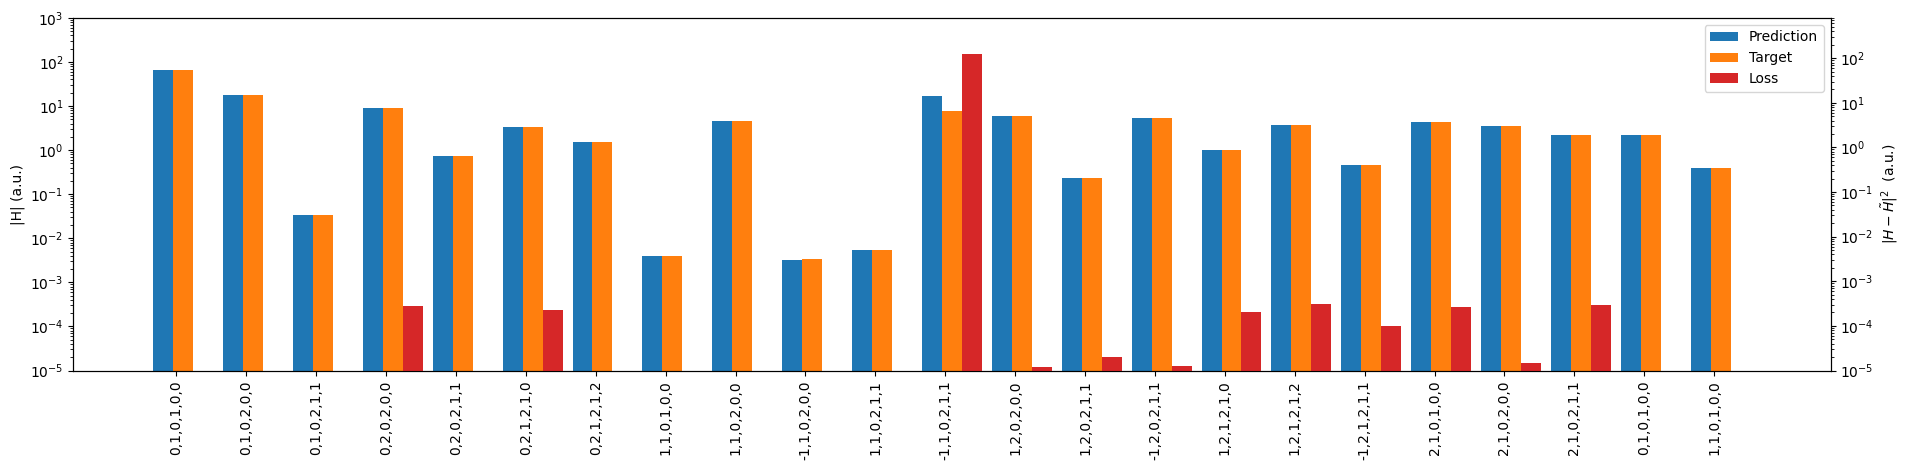

In [35]:
from mlelec.utils.plot_utils import plot_block_errors
fig, ax, ax_loss = plot_block_errors(ml_data.target_train, pred_ridges, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

In [36]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, _to_matrix
reconstructed_uncoupled = _to_uncoupled_basis(pred_ridges,  device=model.device) # Convert the coupled blocks to uncoupled

# Recover the predicted matrices for the training set 
fock_predictions_train = _to_matrix(
   reconstructed_uncoupled,
    ml_data.train_frames,
     ml_data.aux_data['orbitals'],
    device=model.device,
)

print(f'Train RMSE: {torch.sqrt(torch.linalg.norm((fock_predictions_train - ml_data.target.tensor[ml_data.train_idx]))**2 / len(ml_data.train_idx) )}')

Train RMSE: 11.047005184719431


Validation

In [37]:
pred_ridges_val  = model.predict_ridge_analytical()

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [ ]:
block_losses = {}
for k,b in ml_data.target_val.items():
    block_losses[tuple(k.values)] = torch.linalg.norm(b.values - pred_ridges_val.block(k).values)**2
loss_ = sum(block_losses.values()) # sum of squares losses of all the blocks 


# Get errors in eV from here 
normalizing_factor = 7 # TOFIX frames[0].get_global_number_of_atoms()*ml_data.molecule_data.basis.
print(f"Validation Loss {np.sqrt(loss_/normalizing_factor) * Hartree*1000:.2f} meV")

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 500
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in ml_data.target.blocks.keys.values.tolist()]
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
# ax_loss = ax.twinx()
# s = (0,0,0)
prediction_ = np.array([torch.linalg.norm(b.values) for b in pred_ridges_val])
target_ = np.array([torch.linalg.norm(b.values) for b in ml_data.target_val])
loss_ = np.array([torch.linalg.norm(b.values-b1.values)**2 for b,b1 in zip(ml_data.target_val,pred_ridges_val)])
print(np.sum(loss_))

loss_blocks = list(block_losses.values())

x_ = 3.5*np.arange(len(loss_blocks))

labels = []
handles = []
pl = ax.bar(x_, prediction_, label = 'pred', width = 1, color = 'tab:blue');
handles.append(pl)
labels.append('Prediction')
pl = ax.bar(x_+1, target_, alpha = 1, label = 'target', width = 1, color = 'tab:orange');
handles.append(pl)
labels.append('Target')

# pl = ax_loss.bar(x_+2, loss_, alpha = 1, label = 'target', width = 1, color = 'tab:red');
# handles.append(pl)
# labels.append('Loss')

# ax.set_ylim(1e-7, 1000)
ax.set_xticks(3.5*np.arange(len(loss_blocks))+3.5/3-0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(handles, labels, loc = 'best')
ax.set_ylabel('|H|')
# ax_loss.set_ylabel('Loss')
# ax_loss.set_yscale('log')
# # ax_loss.set_ylim(1e-7)
ax.set_yscale('log')
ax.set_title('Performance on the training set')
fig.tight_layout()

In [ ]:
reconstructed_uncoupled = _to_uncoupled_basis(pred_ridges_val,  device=model.device) # Convert the coupled blocks to uncoupled

# Recover the predicted matrices for the validation set 
fock_predictions_val = _to_matrix(
   reconstructed_uncoupled,
    ml_data.val_frames,
     ml_data.aux_data['orbitals'],
    device=model.device,
)

print(f'Validation RMSE: {torch.sqrt(torch.linalg.norm((fock_predictions_val - ml_data.target.tensor[ml_data.val_idx]))**2 / len(ml_data.val_idx) )}')

Predict properties from the trained Hamiltonians

In [ ]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"
import torch
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
# import mlelec.metrics as mlmetrics

In [ ]:
def compute_dipole_moment(frames, fock_predictions, overlaps):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [ ]:
from IPython.utils import io
import mlelec.metrics as mlmetrics
# with HiddenPrints():

fock_reference_train = ml_data.molecule_data.target['fock'][ml_data.train_idx] 
fock_reference_val = ml_data.molecule_data.target['fock'][ml_data.val_idx] 

with io.capture_output() as captured:
   # Compute the dipole moments of reference Fock matrix
    dipole_reference_train = compute_dipole_moment(
        ml_data.train_frames,
        fock_reference_train,
        ml_data.molecule_data.aux_data["overlap"][ml_data.train_idx],
    )
    # convert prediction back to pyscf order before passing to pyscf 
    fock_predictions_train = unfix_orbital_order(
        fock_predictions_train,
        ml_data.train_frames,
        ml_data.molecule_data.aux_data["orbitals"],
    )
    # Compute the dipole moments of the prediction of the training set
    dipole_prediction_train = compute_dipole_moment(
        ml_data.train_frames,
        fock_predictions_train,
        ml_data.molecule_data.aux_data["overlap"][ml_data.train_idx],
    )
    

    # Repeat the procedure above for the validation set 
    dipole_reference_val = compute_dipole_moment(
        ml_data.val_frames,
        fock_reference_val,
        ml_data.molecule_data.aux_data["overlap"][ml_data.val_idx],
    )
    
    fock_predictions_val = unfix_orbital_order(
        fock_predictions_val,
        ml_data.val_frames,
        ml_data.molecule_data.aux_data["orbitals"],
    )

    dipole_prediction_val = compute_dipole_moment(
        ml_data.val_frames,
        fock_predictions_val,
        ml_data.molecule_data.aux_data["overlap"][ml_data.val_idx],
    )

In [ ]:
square_loss = mlmetrics.L2_loss(dipole_reference_train , dipole_prediction_train)
print(f"RMSE on dipoles (training set) (a.u.):  {torch.sqrt(square_loss / len(dipole_prediction_train)).item()}")

square_loss = mlmetrics.L2_loss(dipole_reference_val , dipole_prediction_val)
print(f"RMSE on dipoles (validation set) (a.u.): {torch.sqrt(square_loss / len(dipole_prediction_val)).item()}")

Train the model

In [ ]:
from cmath import inf
best = inf
early_stop_criterion = 50

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 20, verbose = True)

In [ ]:
val_interval = 10
losses = []
early_stop_count = 0
nepochs = 800
Path('model').mkdir(exist_ok = True)

In [ ]:
for epoch in range(nepochs):
    
    model.train(True)
    train_loss = 0
    
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        pred = model(data["input"], return_type = "coupled_blocks", batch_indices = data["idx"])  
        loss = loss_fn(pred, data["output"])
        train_loss += loss
        loss.backward()
        optimizer.step()
    losses.append(train_loss.item())
    scheduler.step(train_loss)
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        
        for i, data in enumerate(val_dl):
            pred = model(data["input"], return_type = "coupled_blocks", batch_indices = data["idx"])
            vloss = loss_fn(pred, data["output"])
            val_loss += vloss.item()
        new_best = val_loss < best
        
        if new_best:
            best = val_loss
            early_stop_count = 0
        else:
            early_stop_count += 1
            
        if early_stop_count > early_stop_criterion:
            print(f"\n\nEarly stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")
            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            break
            
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>5d}, train. loss: {train_loss/len(ml_data.train_idx):>10.6e}. Val. loss: {val_loss/len(ml_data.val_idx):>10.6e}")

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(losses)*Hartree**2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('Number of epochs')
ax.set_ylabel(r'Loss function ($\mathrm{eV}^2$)')